/home/juls/Adaptive-Filter-for-Acoustic-Signal-Segmentation/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [20/1000], Train Loss: 0.4989, Val Loss: 0.4637
Epoch [40/1000], Train Loss: 0.4168, Val Loss: 0.4018
Epoch [60/1000], Train Loss: 0.3424, Val Loss: 0.3869
Epoch [80/1000], Train Loss: 0.2744, Val Loss: 0.3181
Epoch [100/1000], Train Loss: 0.2475, Val Loss: 0.3024
Epoch [120/1000], Train Loss: 0.2136, Val Loss: 0.2659
Epoch [140/1000], Train Loss: 0.1846, Val Loss: 0.2479
Epoch [160/1000], Train Loss: 0.1780, Val Loss: 0.2459
Epoch [180/1000], Train Loss: 0.1678, Val Loss: 0.2391
Epoch [200/1000], Train Loss: 0.1629, Val Loss: 0.2363
Epoch [220/1000], Train Loss: 0.1582, Val Loss: 0.2369
Epoch [240/1000], Train Loss: 0.1502, Val Loss: 0.2311
Epoch [260/1000], Train Loss: 0.1516, Val Loss: 0.2303
Epoch [280/1000], Train Loss: 0.1546, Val Loss: 0.2303
Epoch [300/1000], Train Loss: 0.1553, Val Loss: 0.2301
Epoch [320/1000], Train Loss: 0.1491, Val Loss: 0.2302
Epoch [340/1000], Train Loss: 0.1521, Val Loss: 0.2302
Epoch [360/1000], Train Loss: 0.1493, Val Loss: 0.2302
Epoch [380/100

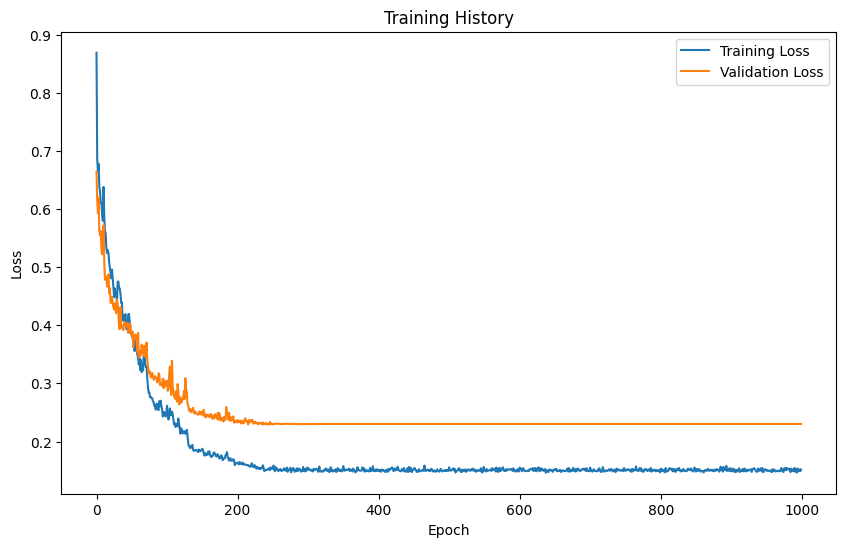

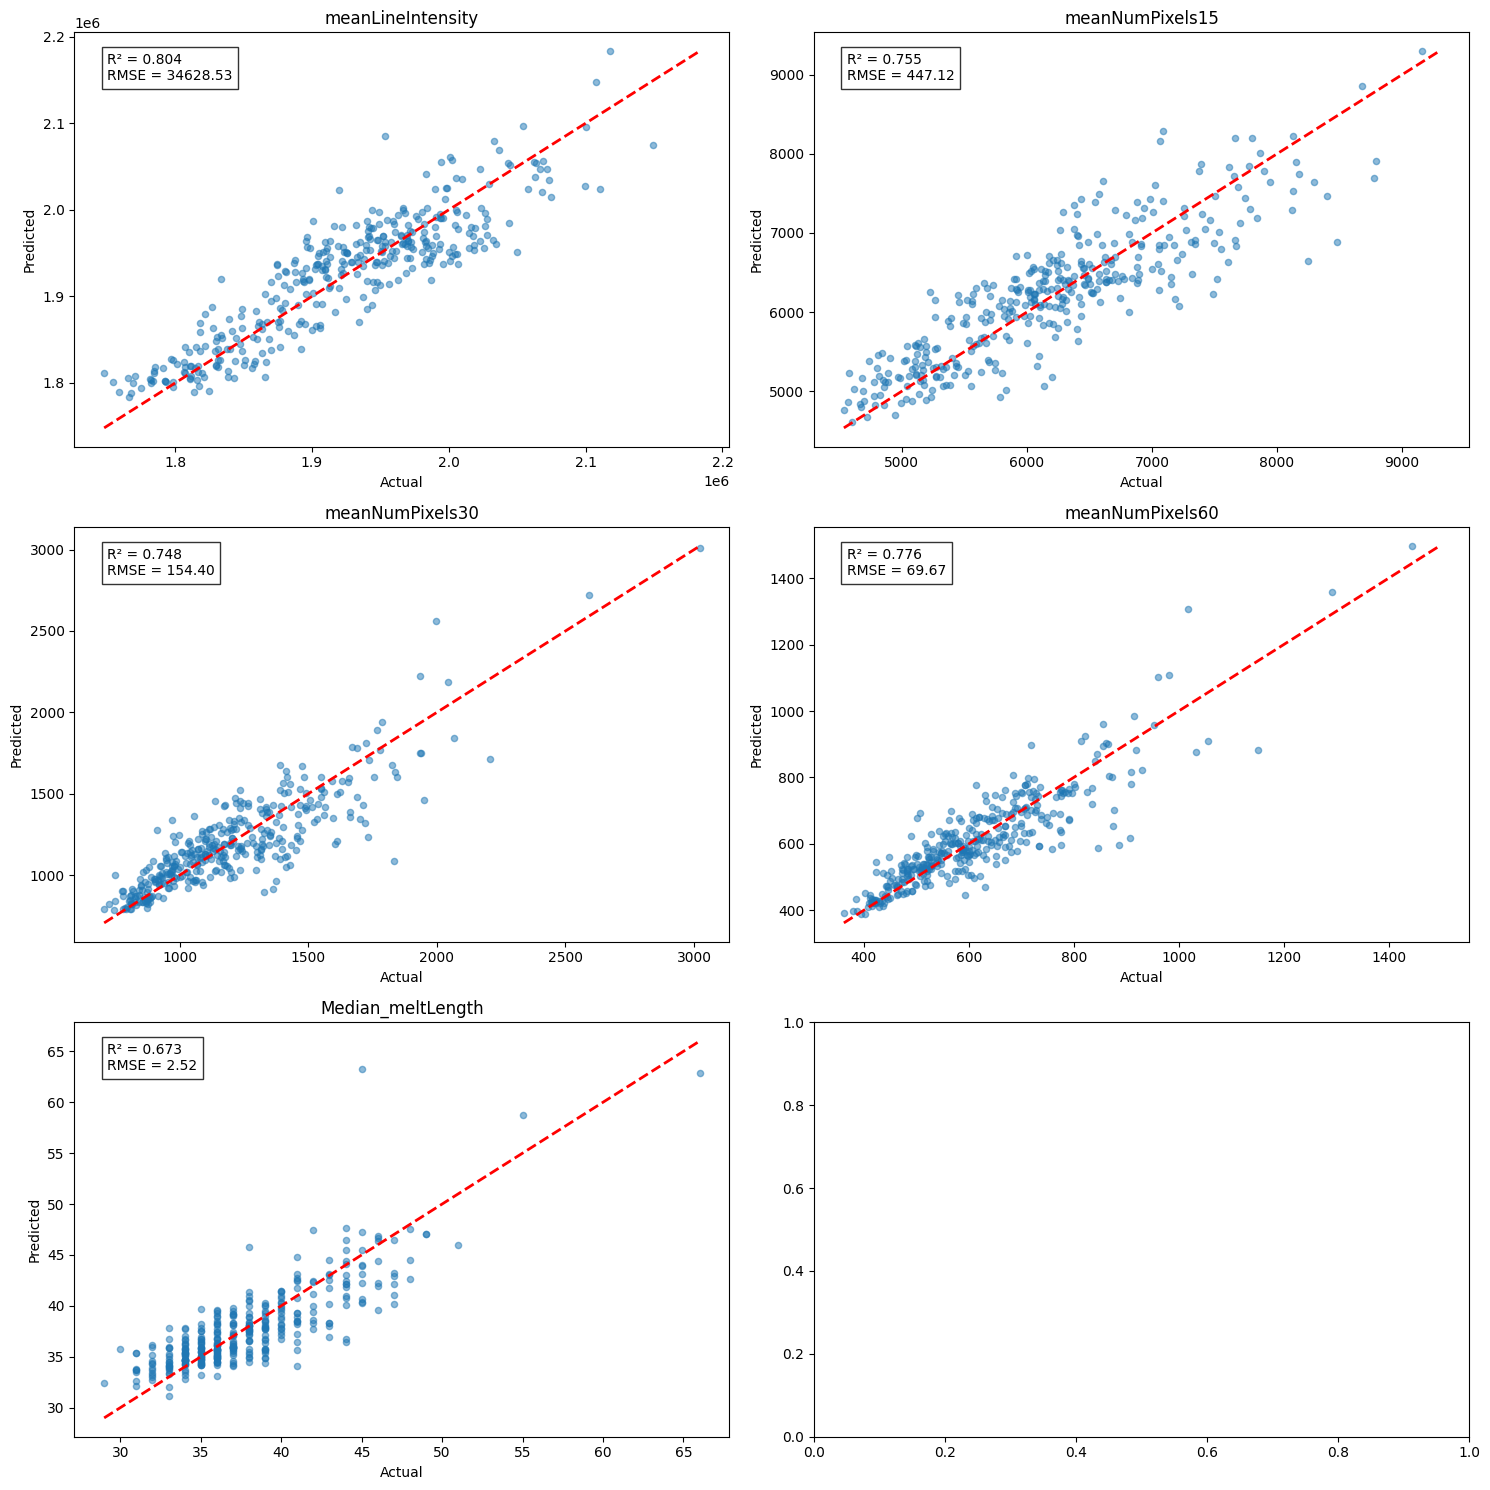


Model Performance Metrics:

meanLineIntensity:
R² Score: 0.804
RMSE: 34628.53
Mean Actual Value: 1921495.04
Std Dev Actual: 78392.12

meanNumPixels15:
R² Score: 0.755
RMSE: 447.12
Mean Actual Value: 6182.15
Std Dev Actual: 904.21

meanNumPixels30:
R² Score: 0.748
RMSE: 154.40
Mean Actual Value: 1195.44
Std Dev Actual: 307.84

meanNumPixels60:
R² Score: 0.776
RMSE: 69.67
Mean Actual Value: 612.06
Std Dev Actual: 147.36

Median_meltLength:
R² Score: 0.673
RMSE: 2.52
Mean Actual Value: 37.85
Std Dev Actual: 4.42


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Custom dataset class
class ProcessDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Neural Network Model
class MultiOutputNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        super(MultiOutputNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                #nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                #nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Output layer
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        
    def forward(self, x):
        x = self.hidden_layers(x)
        return self.output_layer(x)

# Load and preprocess data
data = pd.read_csv('data.txt')

# Extract features and create engineered features
geometric_features = ['X_Start', 'Y_Start', 'X_End', 'Y_end', 'Z', 'Overhang', 'Wall']
X = data[geometric_features + ['Power']].copy()

# Add engineered features
X['X_Length'] = np.abs(X['X_End'] - X['X_Start'])
X['Y_Length'] = np.abs(X['Y_end'] - X['Y_Start'])
X['Distance'] = np.sqrt(X['X_Length']**2 + X['Y_Length']**2)
X['Power_Z'] = X['Power'] * X['Z']
X['Power_Overhang'] = X['Power'] * X['Overhang']

# Process targets
target_vars = [
    'meanLineIntensity',
    'meanNumPixels15',
    'meanNumPixels30',
    'meanNumPixels60',
    'Median_meltLength'
]
y = data[target_vars]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Create datasets and dataloaders
train_dataset = ProcessDataset(X_train_scaled, y_train_scaled)
test_dataset = ProcessDataset(X_test_scaled, y_test_scaled)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
input_size = X_train_scaled.shape[1]
hidden_sizes = [512, 512, 256, 128]  
output_size = len(target_vars)

model = MultiOutputNN(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
num_epochs = 1000
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    
    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(val_loss / len(test_loader))
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {test_losses[-1]:.4f}')

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

# Evaluate model
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for i, target in enumerate(target_vars):
    if i < len(axes):
        ax = axes[i]
        ax.scatter(y_test[target], y_pred[:, i], alpha=0.5, s=20)
        
        min_val = min(y_test[target].min(), y_pred[:, i].min())
        max_val = max(y_test[target].max(), y_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title(f'{target}')
        
        r2 = r2_score(y_test[target], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_test[target], y_pred[:, i]))
        ax.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.2f}', 
                transform=ax.transAxes, 
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print performance metrics
print("\nModel Performance Metrics:")
for i, target in enumerate(target_vars):
    r2 = r2_score(y_test[target], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred[:, i]))
    print(f"\n{target}:")
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Mean Actual Value: {y_test[target].mean():.2f}")
    print(f"Std Dev Actual: {y_test[target].std():.2f}")

Target (bulk) values:
meanLineIntensity: 1908859.52
meanNumPixels15: 6004.32
meanNumPixels30: 1094.31
meanNumPixels60: 563.85
Median_meltLength: 36.00

Found 944 cases with large deviations (>20.0% from target values)


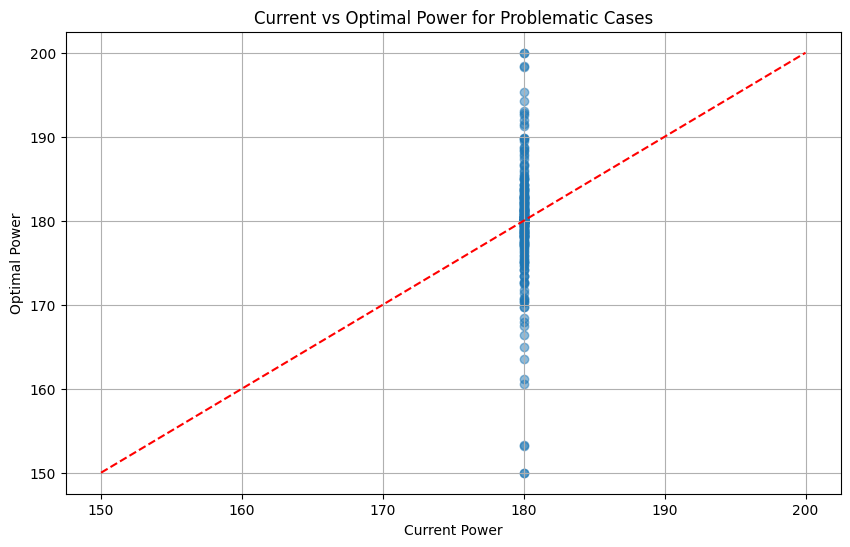

/tmp/ipykernel_10570/191500204.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([current_errors, optimal_errors], labels=['Current', 'Optimal'])
/tmp/ipykernel_10570/191500204.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([current_errors, optimal_errors], labels=['Current', 'Optimal'])
/tmp/ipykernel_10570/191500204.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([current_errors, optimal_errors], labels=['Current', 'Optimal'])
/tmp/ipykernel_10570/191500204.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' sin

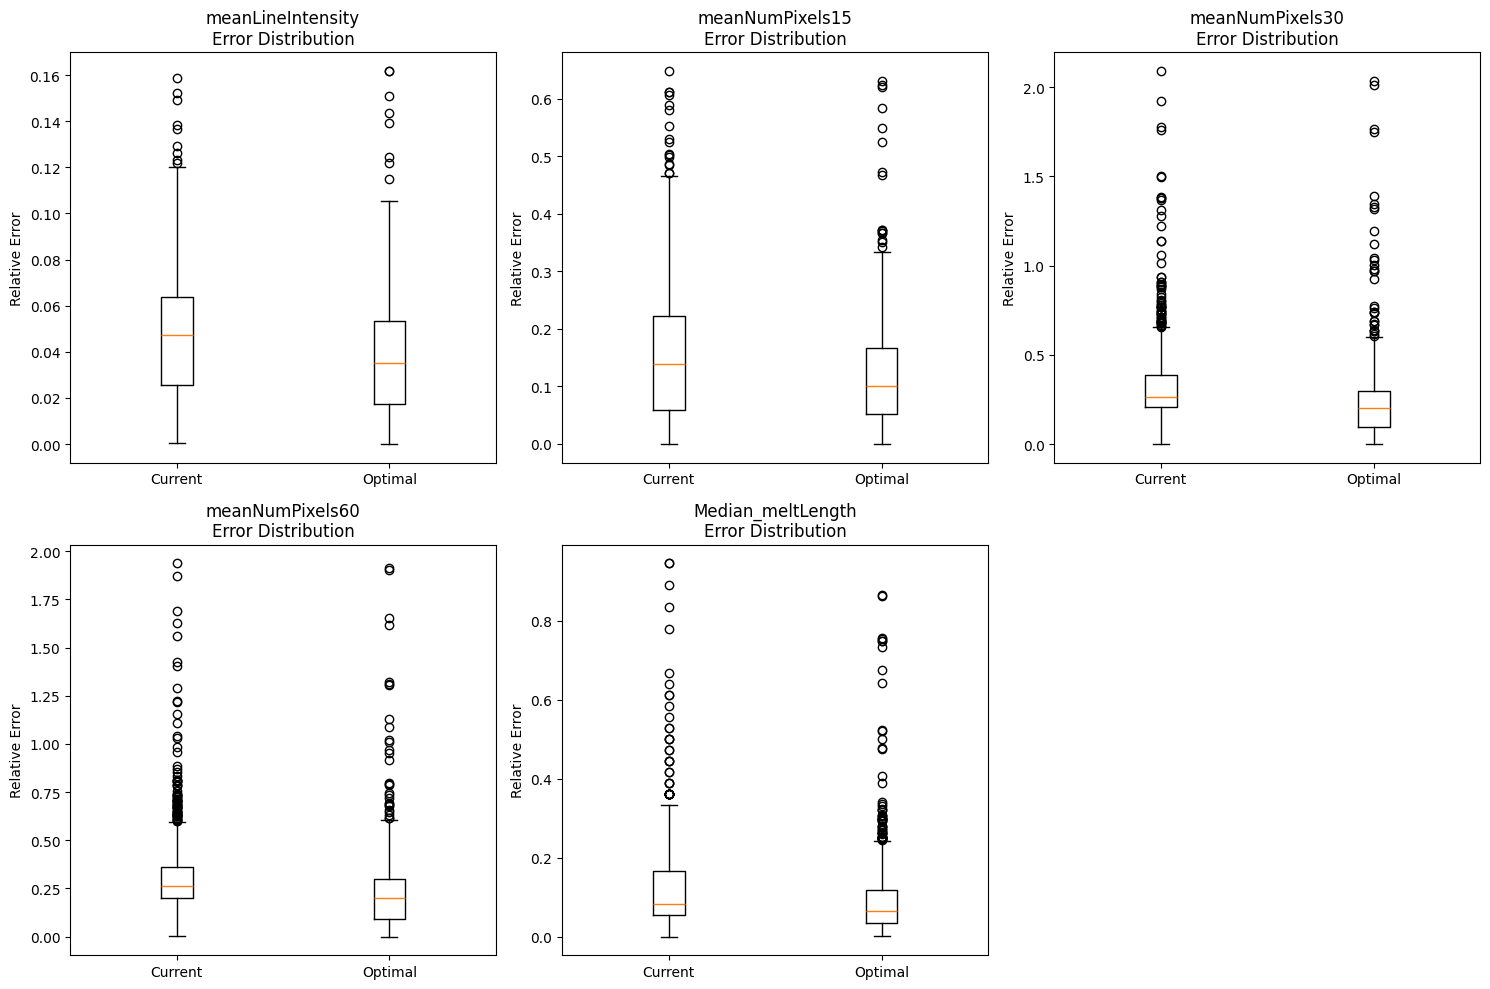


Optimization Results Summary:
Total cases analyzed: 944
Average current power: 180.00
Average optimal power: 179.95
Average power change: -0.05

Detailed results saved to 'optimization_results.csv'


In [11]:
import numpy as np
import torch
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt

# Define feature names
geometric_feature_names = ['X_Start', 'Y_Start', 'X_End', 'Y_end', 'Z', 'Overhang', 'Wall']
engineered_feature_names = ['X_Length', 'Y_Length', 'Distance', 'Power_Z', 'Power_Overhang']
all_feature_names = geometric_feature_names + ['Power'] + engineered_feature_names

def prepare_features(geometric_features, power):
    """Prepare feature vector including engineered features"""
    features = {}
    
    # Add geometric features
    for i, name in enumerate(geometric_feature_names):
        features[name] = geometric_features[i]
        
    # Add power
    features['Power'] = power
    
    # Calculate engineered features
    features['X_Length'] = abs(geometric_features[2] - geometric_features[0])  # X_End - X_Start
    features['Y_Length'] = abs(geometric_features[3] - geometric_features[1])  # Y_end - Y_Start
    features['Distance'] = np.sqrt(features['X_Length']**2 + features['Y_Length']**2)
    features['Power_Z'] = power * geometric_features[4]  # Power * Z
    features['Power_Overhang'] = power * geometric_features[5]  # Power * Overhang
    
    return pd.DataFrame([features])

# Function to predict outputs using the trained model
def predict_outputs(model, scaler_X, scaler_y, features_df):
    model.eval()
    with torch.no_grad():
        X_scaled = scaler_X.transform(features_df)
        X_tensor = torch.FloatTensor(X_scaled)
        y_pred_scaled = model(X_tensor).numpy()
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
    return y_pred[0]

# Objective function for optimization
def objective_function(power, model, scaler_X, scaler_y, geometric_features, target_values):
    # Prepare feature vector
    features_df = prepare_features(geometric_features, power[0])
    
    # Predict outputs
    predicted = predict_outputs(model, scaler_X, scaler_y, features_df)
    
    # Calculate weighted error
    target_array = np.array(list(target_values))
    relative_error = np.sum(((predicted - target_array) / target_array) ** 2)
    
    return relative_error

# Calculate bulk (target) values from non-edge, non-overhang cases
bulk_data = data[(data['Overhang'] == 0) & (data['Wall'] == 0)]
target_values = bulk_data[target_vars].median()

print("Target (bulk) values:")
for var, val in target_values.items():
    print(f"{var}: {val:.2f}")

# Calculate deviations and find problematic cases
relative_deviations = data[target_vars].apply(lambda x: abs(x - target_values[x.name])/target_values[x.name])
threshold = 0.20
large_deviation_mask = (relative_deviations > threshold).any(axis=1)
problematic_cases = data[large_deviation_mask].copy()

print(f"\nFound {len(problematic_cases)} cases with large deviations (>{threshold*100}% from target values)")

# Find optimal power for each problematic case
results = []
for idx, row in problematic_cases.iterrows():
    # Extract geometric features in correct order
    geom_features = row[geometric_feature_names].values
    current_power = row['Power']
    
    # Optimize power
    bounds = [(150, 200)]  # Power bounds
    result = minimize(
        objective_function,
        x0=[current_power],
        args=(model, scaler_X, scaler_y, geom_features, target_values),
        method='L-BFGS-B',
        bounds=bounds
    )
    
    optimal_power = result.x[0]
    
    # Calculate predictions with optimal power
    optimal_features_df = prepare_features(geom_features, optimal_power)
    optimal_predictions = predict_outputs(model, scaler_X, scaler_y, optimal_features_df)
    
    # Store results
    results.append({
        'index': idx,
        'current_power': current_power,
        'optimal_power': optimal_power,
        'original_values': row[target_vars].to_dict(),
        'predicted_values': dict(zip(target_vars, optimal_predictions)),
        'geometry': row[geometric_feature_names].to_dict(),
        'optimization_success': result.success,
        'final_error': result.fun
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot current vs optimal power
plt.figure(figsize=(10, 6))
plt.scatter(results_df['current_power'], results_df['optimal_power'], alpha=0.5)
plt.plot([150, 200], [150, 200], 'r--')  # Diagonal line
plt.xlabel('Current Power')
plt.ylabel('Optimal Power')
plt.title('Current vs Optimal Power for Problematic Cases')
plt.grid(True)
plt.show()

# Plot improvement in predictions
plt.figure(figsize=(15, 10))
for i, target in enumerate(target_vars, 1):
    plt.subplot(2, 3, i)
    current_errors = np.array([abs(case['original_values'][target] - target_values[target])/target_values[target] 
                             for case in results])
    optimal_errors = np.array([abs(case['predicted_values'][target] - target_values[target])/target_values[target] 
                             for case in results])
    
    plt.boxplot([current_errors, optimal_errors], labels=['Current', 'Optimal'])
    plt.title(f'{target}\nError Distribution')
    plt.ylabel('Relative Error')
plt.tight_layout()
plt.show()

# Print summary statistics and save results
print("\nOptimization Results Summary:")
print(f"Total cases analyzed: {len(results_df)}")
print(f"Average current power: {results_df['current_power'].mean():.2f}")
print(f"Average optimal power: {results_df['optimal_power'].mean():.2f}")
print(f"Average power change: {(results_df['optimal_power'] - results_df['current_power']).mean():.2f}")

# Save detailed results
output_df = pd.DataFrame([{
    'index': r['index'],
    'current_power': r['current_power'],
    'optimal_power': r['optimal_power'],
    'power_change': r['optimal_power'] - r['current_power'],
    'error_improvement': r['final_error'],
    'optimization_success': r['optimization_success'],
    **r['geometry'],
    **{f'original_{k}': v for k, v in r['original_values'].items()},
    **{f'predicted_{k}': v for k, v in r['predicted_values'].items()},
    **{f'target_{k}': v for k, v in target_values.items()}
} for r in results])

output_df.to_csv('optimization_results.csv', index=False)
print("\nDetailed results saved to 'optimization_results.csv'")